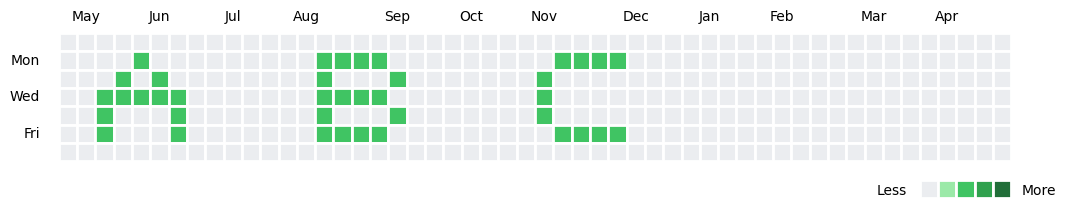

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import calendar
from datetime import datetime

# Define commit color shades (lighter means fewer commits)
COLORS = ["#ebedf0", "#9be9a8", "#40c463", "#30a14e", "#216e39"]

# Define a simple 5x5 pixel font for letters A-Z
LETTER_MAP = {
    " ": ["     ", "     ", "     ", "     ", "     "],
    "A": ["  #  ", " # # ", "#####", "#   #", "#   #"],
    "B": ["#### ", "#   #", "#### ", "#   #", "#### "],
    "C": [" ####", "#    ", "#    ", "#    ", " ####"],
    "D": ["###  ", "#  # ", "#   #", "#  # ", "###  "],
    "E": ["#####", "#    ", "#####", "#    ", "#####"],
    "F": ["#####", "#    ", "#####", "#    ", "#    "],
}

def generate_commit_data():
    """Generate random commit activity levels for a 7x52 grid"""
    return np.random.randint(0, 1, (8, 52))

def apply_letter_overlay(grid, text):
    """Overlay letters onto the commit grid by reducing intensity"""
    start_x, start_y = 2, 2  # Positioning letters within grid
    
    for letter in text.upper():
        if letter in LETTER_MAP:
            letter_grid = LETTER_MAP[letter]
            for row in range(len(letter_grid)):
                for col in range(len(letter_grid[row])):
                    if letter_grid[row][col] == "#":
                        x, y = start_x + col, start_y + row
                        if 0 <= x < 52 and 0 <= y < 7:
                            grid[y, x] = max(0, grid[y, x] + 2)  # Make it lighter
            start_x += 6  # Move to next letter position

    return grid

def plot_commit_graph(grid):
    """Plot the commit graph with text overlay"""
    fig, ax = plt.subplots(figsize=(13, 3))

    # Plot each grid cell
    for y in range(8):
        for x in range(52):
            ax.add_patch(plt.Rectangle((x, -y), 1, 1,ec='white',lw=2, color=COLORS[grid[y, x]]))

    # Plot legend
    for i, x in enumerate(range(47,52)):
        ax.add_patch(plt.Rectangle((x, -9), 1, 1,ec='white',lw=2, color=COLORS[i]))
    ax.text(45.5,-9,"Less", ha="center", va="bottom", fontsize=10, color="black")
    ax.text(53.5,-9,"More", ha="center", va="bottom", fontsize=10, color="black")
    

    # Add Y-axis labels (Mon, Wed, Fri)
    day_labels = {1.5: "Mon", 3.5: "Wed", 5.5: "Fri"}
    for y in day_labels:
        ax.text(-1, -y, day_labels[y], va="center", ha="right", fontsize=10, color="black")

    # Add X-axis labels (Months)
    current_month = datetime.now().month  # Get the current month

    month_labels = []
    month_starts = []
    
    # Estimate month divisions based on 52 weeks
    weeks_per_month = 4.33  # Approximate average
    weeks_passed = 0

    for i in range(12):
        month = (current_month + i - 1) % 12 + 1  # Cycle through months starting from the current one
        month_labels.append(calendar.month_abbr[month])
        month_starts.append(int(weeks_passed))
        weeks_passed += weeks_per_month

    for i, month in enumerate(month_labels):
        if month_starts[i] < 52:  # Prevent overflow beyond 52 weeks
            ax.text(month_starts[i]+1.5, 0.5, month, ha="center", va="bottom", fontsize=10, color="black")

    ax.set_xlim(0, 55)
    ax.set_ylim(-9, 0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_aspect('equal')

    plt.show()

# if __name__ == "__main__":
commit_data = generate_commit_data()

commit_data = apply_letter_overlay(commit_data, "A B C")

plot_commit_graph(commit_data)

## Github

In [7]:
import os
import random
import datetime
import shutil
from git import Repo, GitCommandError
import time
import tempfile

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configuration variables
REPO_URL = os.getenv("REPO_URL", "https://github.com/your-username/your-repo.git")
BRANCH = os.getenv("GIT_BRANCH", "main")
COMMIT_MESSAGE = os.getenv("GIT_COMMIT_MESSAGE", "Automated commit to populate contribution graph")
DAYS_TO_BACKFILL = int(os.getenv("MAX_DAYS", 3))
MIN_COMMITS_PER_DAY = int(os.getenv("MIN_COMMITS_PER_DAY", 1))
MAX_COMMITS_PER_DAY = int(os.getenv("MAX_COMMITS_PER_DAY", 2))
GIT_USERNAME = os.getenv("GIT_USERNAME", "your-username")
GIT_EMAIL = os.getenv("GIT_EMAIL", "your-email@example.com")
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN", "")

# Clone the repo to a temporary directory
temp_dir = tempfile.mkdtemp()
print(f"Cloning {REPO_URL} (branch: {BRANCH}) into {temp_dir}")

# set up repo
repo = Repo.clone_from(
        REPO_URL,
        temp_dir,
        branch=BRANCH
    )

# Define dummy file path
file_path = os.path.join(temp_dir, "dummy.txt")

# Set Git user identity
repo.config_writer().set_value("user", "name", GIT_USERNAME).release()
repo.config_writer().set_value("user", "email", GIT_EMAIL).release()

# Ensure at least one commit exists before pushing
if not repo.head.is_valid():
    repo.index.add([file_path])
    repo.index.commit("Initial commit to set up repository")


# Generate commits for past DAYS_TO_BACKFILL days
start_date = datetime.datetime.now() - datetime.timedelta(days=DAYS_TO_BACKFILL)

for i in range(DAYS_TO_BACKFILL):
    commit_date = start_date + datetime.timedelta(days=i)
    commit_date_str = commit_date.strftime("%Y-%m-%dT%H:%M:%S")  # FIXED format

    num_commits = random.randint(MIN_COMMITS_PER_DAY, MAX_COMMITS_PER_DAY)

    for _ in range(num_commits):
        with open(file_path, "a") as f:
            f.write(f"Commit on {commit_date}\n")

        repo.index.add([file_path])
        repo.index.commit(COMMIT_MESSAGE, author_date=commit_date_str, commit_date=commit_date_str)  # FIXED


# Push changes
origin = repo.remote(name="origin")
origin.push(refspec=f"{BRANCH}:{BRANCH}", force=True)

# Cleanup
# shutil.rmtree(LOCAL_REPO_PATH, ignore_errors=True)

Cloning https://github.com/justinj-evans/github-activity-graph-tester (branch: main) into C:\Users\LO79CF~1\Temp\tmpaz39tm5r
